In [1]:
import os, sys
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.train import Checkpoint
from tensorflow import GradientTape
from PIL import Image
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Model
from IPython.display import clear_output
import pickle

In [2]:
os.getcwd()

'c:\\Users\\Mónica Emmanuelle\\Documents\\Datasets\\Models'

In [4]:
current_folder = os.getcwd() #This line of code change in jupyter notebooks!!!
project = "test"
project_path = os.path.join(current_folder, project)
train_path = os.path.join(project_path, "train")
target_path = os.path.join(project_path, "target")
output_path = os.path.join(project_path, "output")
checkpoints_path = os.path.join(project_path, "checkpoints")
model_path = os.path.join(project_path, "model")
user_input_path = os.path.join(model_path, "input")
user_output_path = os.path.join(model_path, "output")
if not os.path.exists(user_input_path):
    os.mkdir(user_input_path)
if not os.path.exists(user_output_path):
    os.mkdir(user_output_path)

In [5]:
files = os.listdir(train_path)
user_files = os.listdir(user_input_path)
len(files), len(user_files)

(60, 10)

In [6]:
# Preprocess the images
BATCH_SIZE = 1
IMAGE_SIZE = 256

def resize(image, target, size):
    image = tf.image.resize(image, [size, size])
    target = tf.image.resize(target, [size, size])
    return image, target

def normalize(image, target):
    image = (image / 127.5) - 1
    target = (target / 127.5) - 1
    return image, target

def random_jitter(image, target, size):
    image, target = resize(image, target, size)
    print(image.shape, target.shape)
    stacked_image = tf.stack([image, target], axis = 0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMAGE_SIZE, IMAGE_SIZE, 3])
    image, target = cropped_image[0], cropped_image[1]
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_flip_left_right(image)
        target = tf.image.flip_left_right(image)
    return image, target

def load_image(filename, jitter = False):
    image = tf.cast(tf.image.decode_jpeg(tf.io.read_file(train_path+"/"+filename), 3), tf.float32)[..., :3]
    target = tf.cast(tf.image.decode_jpeg(tf.io.read_file(target_path+"/"+filename), 3), tf.float32)[..., :3]
    image, target = resize(image, target, IMAGE_SIZE)
    if jitter:
        image, target = random_jitter(image, target, IMAGE_SIZE+30)
    image, target = normalize(image, target)
    return image, target

def load_train_image(filename):
    return load_image(filename, False)

def load_test_image(filename):
    return load_image(filename, False)

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(files)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [8]:
user_dataset = tf.data.Dataset.from_tensor_slices(user_files)
user_dataset = user_dataset.map(load_train_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
user_dataset = user_dataset.batch(BATCH_SIZE)

In [9]:
for image, target in train_dataset.take(1):
    print(image.shape, target.shape)

(1, 256, 256, 3) (1, 256, 256, 3)


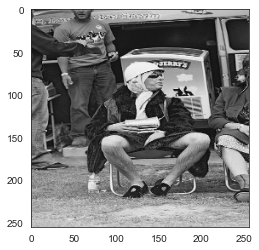

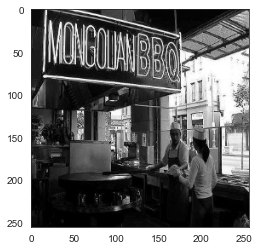

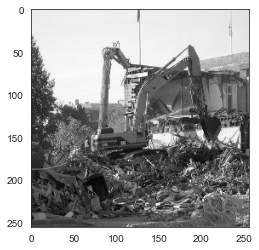

In [10]:
for image, target in train_dataset.take(3):
    with sns.axes_style("white"):
        plt.imshow(((image[0, ...]) +1) /2)
        plt.show()

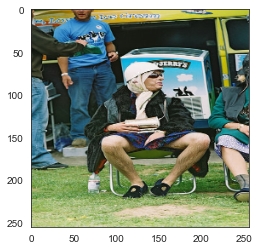

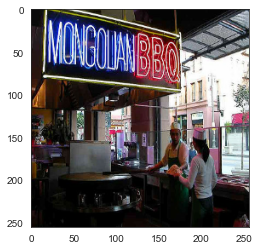

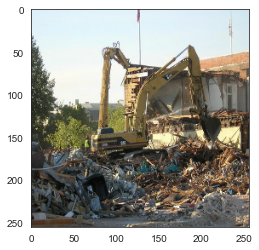

In [11]:
for image, target in train_dataset.take(3):
    with sns.axes_style("white"):
        plt.imshow(((target[0, ...]) +1) /2)
        plt.show()

In [12]:
# MODEL
def down_block(filters, batchnorm = False):
    model = keras.Sequential()
    initializer = tf.random_normal_initializer(0, 0.02)
    model.add(Conv2D(filters, kernel_size=4, strides=2, padding="same", kernel_initializer=initializer, use_bias = not batchnorm))
    if batchnorm:
        model.add(BatchNormalization())
    model.add(LeakyReLU())
    return model


def up_block(filters, dropout = False):
    model = keras.Sequential()
    initializer = tf.random_normal_initializer(0, 0.02)
    model.add(Conv2DTranspose(filters, kernel_size=4, strides=2, padding="same", kernel_initializer=initializer, use_bias = False))
    if dropout:
        model.add(Dropout(0.5))
    model.add(ReLU())
    return model

In [13]:
class Generator():
    def __init__(self):
        self.input = Input(shape=[None, None, 3])
        self.down_stack = [
            down_block(64),                     #batch_size, 128, 128, 64  
            down_block(128, batchnorm = True),  #batch_size, 64, 64, 128
            down_block(256, batchnorm = True),  #batch_size, 32, 32, 256
            down_block(512, batchnorm = True),  #batch_size, 16, 16, 512
            down_block(512, batchnorm = True),  #batch_size, 8, 8, 512
            down_block(512, batchnorm = True),  #batch_size, 4, 4, 512
            down_block(512, batchnorm = True),  #batch_size, 2, 2, 512
            down_block(512, batchnorm = True)   #batch_size, 1, 1, 512
        ]
        self.up_stack = [
            up_block(512, dropout = True),      #batch_size, 2, 2, 1024
            up_block(512, dropout = True),      #batch_size, 4, 4, 1024
            up_block(512, dropout = True),      #batch_size, 8, 8, 1024
            up_block(512),                      #batch_size, 16, 16, 1024
            up_block(256),                      #batch_size, 32, 32, 512
            up_block(128),                      #batch_size, 64, 64, 512
            up_block(64)                        #batch_size, 128, 128, 128
        ]
        initializer = tf.random_normal_initializer(0, 0.2)
        self.to_output = Conv2DTranspose(filters = 3, kernel_size=4, strides=2, padding="same", kernel_initializer=initializer, activation="tanh")
        self.make_connections()

    def make_connections(self):
        block = self.input
        skip_connections = []
        for stack in self.down_stack:
            block = stack(block)
            skip_connections.append(block)
        skip_connections = reversed(skip_connections[:-1])
        concat = Concatenate()
        for stack, skip in zip(self.up_stack, skip_connections):
            block = stack(block)
            block = concat([block, skip])
        self.output = self.to_output(block)
        self.model = Model(inputs = self.input, outputs = self.output)

    def loss(self, discount, generated, target):
        LAMBDA = 100
        loss_object = keras.losses.BinaryCrossentropy(from_logits = True)
        gan_loss = loss_object(tf.ones_like(discount), discount)
        l1_loss = tf.reduce_mean(tf.abs(target - generated))
        total_loss = gan_loss + (LAMBDA * l1_loss)
        return total_loss

    def get_model(self):
        return self.model

    def get_optimizer(self):
        self.optimizer = keras.optimizers.Adam(2e-4)
        return self.optimizer

generator = Generator()
generator_model = generator.get_model()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


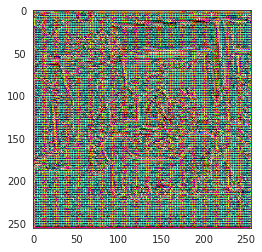

In [14]:
for image, target in train_dataset.take(1):
    output = generator_model(((image+1)*255), training=False)
with sns.axes_style("white"):
    plt.imshow(output[0, ...])

In [15]:
class Discriminator():
    def __init__(self):
        self.target = Input(shape=[None, None, 3])
        self.generated = Input(shape=[None, None, 3])
        self.input = concatenate([self.target, self.generated])
        initializer = tf.random_normal_initializer(0, 0.02)
        self.stack = [
            down_block(64),
            down_block(128, batchnorm = True),
            down_block(256, batchnorm = True),
            down_block(512, batchnorm= True),
        ]
        self.to_output = Conv2D(filters = 1, kernel_size = 4, strides = 1, kernel_initializer=initializer, padding = "same")
        self.make_connections()

    def make_connections(self):
        block = self.input
        for stack in self.stack:
            block = stack(block)
        self.output = self.to_output(block)
        self.model = Model(inputs = [self.target, self.generated], outputs = self.output)

    def loss(self, target, generated):
        loss_object = keras.losses.BinaryCrossentropy(from_logits = True)
        target_loss = loss_object(tf.ones_like(target), target)
        generated_loss = loss_object(tf.zeros_like(generated), generated)
        discount_loss = target_loss + generated_loss
        return discount_loss

    def get_model(self):
        return self.model

    def get_optimizer(self):
        self.optimizer = keras.optimizers.Adam(2e-4)
        return self.optimizer

discriminator = Discriminator()

TensorShape([1, 16, 16, 1])

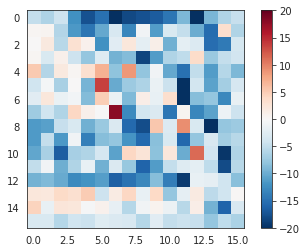

In [16]:
for image, target in train_dataset.take(1):
    disc_out = discriminator.get_model()([(image+1)*255, output], training=False)
with sns.axes_style("white"):
    plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
    plt.colorbar()
disc_out.shape

In [17]:
def train_step(input_image, target):
    with GradientTape() as generator_tape, GradientTape() as discriminator_tape:
        generator_image = generator.model(input_image, training = True)
        discriminator_generated = discriminator.model([generator_image, input_image], training = True)
        discriminator_target = discriminator.model([target, input_image], training = True)
        discriminator_loss = discriminator.loss(discriminator_target, discriminator_generated)
        generator_loss = generator.loss(discriminator_generated, generator_image, target)

        generator_gradients = generator_tape.gradient(generator_loss, generator.model.trainable_variables)
        discriminator_gradients = discriminator_tape.gradient(discriminator_loss, discriminator.model.trainable_variables)
        generator.get_optimizer().apply_gradients(zip(generator_gradients, generator.model.trainable_variables))
        discriminator.get_optimizer().apply_gradients(zip(discriminator_gradients, discriminator.model.trainable_variables))

In [18]:
def make_checkpoints():
    global checkpoint
    checkpoint = Checkpoint(generator_optimizer = generator.get_optimizer(),
                            discriminator_optimizer = discriminator.get_optimizer(),
                            generator = generator.get_model(),
                            discriminator = discriminator.get_model())

def restore_checkpoint():
    last_checkpoint = tf.train.lastest_checkpoint(checkpoints_path)
    checkpoint.restore(last_checkpoint).assert_consumed()

In [19]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for input_image, target in dataset:
            train_step(input_image, target)
        if (epoch + 1) % 25 == 0:
            make_checkpoints()

    path = os.path.join(output_path, "model.pkl")
    with open(path, 'wb') as file:
        pickle.dump(generator.get_model(), file)

In [20]:
train(train_dataset, 3)

KeyboardInterrupt: 